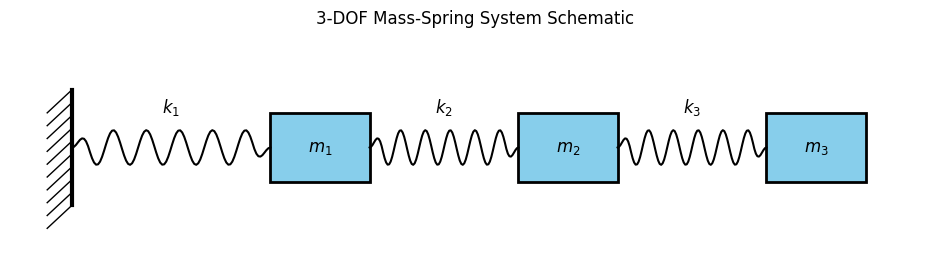

In [15]:
def plot_system_schematic():
    plt.figure(figsize=(12, 3))
    
    # Coordinates
    y = 0
    x_ground = 0
    x_m1 = 2
    x_m2 = 4
    x_m3 = 6
    box_w = 0.8
    box_h = 0.6
    
    # Draw Ground
    plt.plot([x_ground, x_ground], [y-0.5, y+0.5], 'k-', lw=3)
    for i in np.linspace(y-0.5, y+0.5, 10):
        plt.plot([x_ground, x_ground-0.2], [i, i-0.2], 'k-', lw=1) # Ground hatching
    
    # Helper to draw spring
    def draw_spring(x_start, x_end, label):
        # Actual spring length between objects
        start = x_start
        end = x_end
        
        # Zigzag
        n_points = 100
        x_vals = np.linspace(start, end, n_points)
        # Amplitude of zigzag
        amp = 0.15
        # Sine wave for spring look (tapered at ends)
        freq = 6 # Number of coils
        y_vals = y + amp * np.sin(2 * np.pi * freq * (x_vals - start) / (end - start))
        
        # Taper ends to 0
        taper = np.ones_like(y_vals)
        taper[:10] = np.linspace(0, 1, 10)
        taper[-10:] = np.linspace(1, 0, 10)
        y_vals = y + (y_vals - y) * taper

        plt.plot(x_vals, y_vals, 'k-')
        plt.text((start + end)/2, y + 0.3, label, ha='center', fontsize=12)

    # Helper to draw mass
    def draw_mass(x_center, label):
        rect = plt.Rectangle((x_center - box_w/2, y - box_h/2), box_w, box_h, 
                             facecolor='skyblue', edgecolor='black', lw=2)
        plt.gca().add_patch(rect)
        plt.text(x_center, y, label, ha='center', va='center', fontsize=12, fontweight='bold')

    # Draw components
    # Spring 1 (Ground to M1)
    draw_spring(x_ground, x_m1 - box_w/2, '$k_1$')
    
    # Mass 1
    draw_mass(x_m1, '$m_1$')
    
    # Spring 2 (M1 to M2)
    draw_spring(x_m1 + box_w/2, x_m2 - box_w/2, '$k_2$')
    
    # Mass 2
    draw_mass(x_m2, '$m_2$')
    
    # Spring 3 (M2 to M3)
    draw_spring(x_m2 + box_w/2, x_m3 - box_w/2, '$k_3$')
    
    # Mass 3
    draw_mass(x_m3, '$m_3$')

    plt.xlim(-0.5, 7)
    plt.ylim(-1, 1)
    plt.axis('off')
    plt.title('3-DOF Mass-Spring System Schematic')
    plt.show()

plot_system_schematic()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set seed for reproducibility
np.random.seed(42)

# --- System Parameters ---
m = 1.0      # Mass (kg)
k0 = 1000.0  # Base Stiffness (N/m) at T=0

# Mass Matrix (Lumped mass)
M = np.diag([m, m, m])

def get_stiffness_matrix(k1, k2, k3):
    """
    Constructs the stiffness matrix for a 3DOF chain system.
    Ground - k1 - m1 - k2 - m2 - k3 - m3
    """
    K = np.array([
        [k1 + k2, -k2, 0],
        [-k2, k2 + k3, -k3],
        [0, -k3, k3]
    ])
    return K

def get_damping_matrix(M, K, alpha=0.01, beta=0.001):
    """
    Rayleigh Damping: C = alpha*M + beta*K
    """
    return alpha * M + beta * K

def solve_eigenfrequencies(K, M):
    """
    Solves the generalized eigenvalue problem K * phi = w^2 * M * phi
    Returns natural frequencies in Hz.
    """
    evals, evecs = eigh(K, M)
    frequencies = np.sqrt(evals) / (2 * np.pi)
    return frequencies

print("System defined.")

## 1. The Physical System
We consider a chain of 3 masses connected by springs.

In [ ]:
def plot_system_schematic():
    plt.figure(figsize=(10, 3))
    
    y = 0
    x_ground = 0
    x_m1, x_m2, x_m3 = 2, 4, 6
    box_w, box_h = 0.8, 0.6
    
    # Ground
    plt.plot([x_ground, x_ground], [y-0.5, y+0.5], 'k-', lw=3)
    for i in np.linspace(y-0.5, y+0.5, 10):
        plt.plot([x_ground, x_ground-0.2], [i, i-0.2], 'k-', lw=1)
    
    # Helper for spring
    def draw_spring(x_start, x_end, label):
        n_points = 100
        x_vals = np.linspace(x_start, x_end, n_points)
        amp = 0.15
        freq = 6
        y_vals = y + amp * np.sin(2 * np.pi * freq * (x_vals - x_start) / (x_end - x_start))
        # Taper
        taper = np.ones_like(y_vals)
        taper[:10] = np.linspace(0, 1, 10)
        taper[-10:] = np.linspace(1, 0, 10)
        y_vals = y + (y_vals - y) * taper
        plt.plot(x_vals, y_vals, 'k-')
        plt.text((x_start + x_end)/2, y + 0.3, label, ha='center', fontsize=12)

    # Helper for mass
    def draw_mass(x_center, label):
        rect = plt.Rectangle((x_center - box_w/2, y - box_h/2), box_w, box_h, 
                             facecolor='skyblue', edgecolor='black', lw=2)
        plt.gca().add_patch(rect)
        plt.text(x_center, y, label, ha='center', va='center', fontsize=12, fontweight='bold')

    draw_spring(x_ground, x_m1 - box_w/2, '$k_1$')
    draw_mass(x_m1, '$m_1$')
    draw_spring(x_m1 + box_w/2, x_m2 - box_w/2, '$k_2$')
    draw_mass(x_m2, '$m_2$')
    draw_spring(x_m2 + box_w/2, x_m3 - box_w/2, '$k_3$')
    draw_mass(x_m3, '$m_3$')

    plt.xlim(-0.5, 7)
    plt.ylim(-1, 1)
    plt.axis('off')
    plt.title('3-DOF Mass-Spring System')
    plt.show()

plot_system_schematic()

## 2. Simulating System Response (PSD)

In real monitoring, we measure acceleration under ambient excitation (like wind). We simulate this using **White Noise**.
We compute the **Power Spectral Density (PSD)** to find the natural frequencies (peaks).

In [ ]:
def simulate_and_plot_psd(k_vals, label="Healthy"):
    # System Matrices
    K = get_stiffness_matrix(*k_vals)
    C = get_damping_matrix(M, K)
    
    # State Space for simulation
    M_inv = np.linalg.inv(M)
    A = np.vstack([
        np.hstack([np.zeros((3,3)), np.eye(3)]),
        np.hstack([-M_inv @ K, -M_inv @ C])
    ])
    B = np.vstack([np.zeros((3, 3)), M_inv])
    C_out = np.hstack([-M_inv @ K, -M_inv @ C]) # Acceleration output
    D_out = M_inv
    
    # Excitation
    fs = 100.0
    T = 60.0
    t = np.arange(0, T, 1/fs)
    force = np.random.normal(0, 1, (len(t), 3))
    
    # Simulate
    sys = signal.StateSpace(A, B, C_out, D_out)
    _, y, _ = signal.lsim(sys, force, t)
    acc_m3 = y[:, 2] # Measure at Mass 3
    
    # PSD
    f, Pxx = signal.welch(acc_m3, fs, nperseg=1024)
    
    # Plot
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(t[:500], acc_m3[:500], lw=0.5)
    plt.title(f'Time History (Acc M3) - {label}')
    plt.xlabel('Time (s)')
    plt.ylabel('Acc ($m/s^2$)')
    plt.grid(True)
    
    plt.subplot(1, 2, 2)
    plt.semilogy(f, Pxx)
    plt.title(f'PSD - {label}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.xlim(0, 15)
    plt.grid(True)
    
    # Mark peaks
    freqs = solve_eigenfrequencies(K, M)
    for fr in freqs:
        plt.axvline(fr, color='r', linestyle='--', alpha=0.5)
        plt.text(fr, np.max(Pxx), f'{fr:.2f}Hz', rotation=90, va='bottom')
        
    plt.tight_layout()
    plt.show()

simulate_and_plot_psd([k0, k0, k0], "Healthy (20°C)")

## 3. The Environmental Effect (Temperature)

Temperature affects material stiffness. We simulate a dataset of 100 days with varying temperatures.
$$ k(T) = k_0 (1 - \alpha T) $$

In [ ]:
# Parameters
n_samples = 100
temperatures = np.linspace(-10, 40, n_samples)
alpha = 0.001 # Stiffness reduction per degree

healthy_freqs = []

for T in temperatures:
    k_curr = k0 * (1 - alpha * T)
    K = get_stiffness_matrix(k_curr, k_curr, k_curr)
    freqs = solve_eigenfrequencies(K, M)
    healthy_freqs.append(freqs)

healthy_freqs = np.array(healthy_freqs)

# Add measurement noise (simulating peak-picking uncertainty)
noise_level = 0.02 # Hz
healthy_freqs_noisy = healthy_freqs + np.random.normal(0, noise_level, healthy_freqs.shape)

print(f"Generated {n_samples} samples.")

## 4. Visualizing the Data

We observe that frequencies drift significantly with temperature.

In [ ]:
plt.figure(figsize=(12, 5))

# Plot 1: Frequencies vs Temperature
plt.subplot(1, 2, 1)
for i in range(3):
    plt.plot(temperatures, healthy_freqs_noisy[:, i], 'o', alpha=0.5, label=f'Mode {i+1}')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency (Hz)')
plt.title('Frequencies vs Temperature')
plt.legend()
plt.grid(True)

# Plot 2: Correlation
plt.subplot(1, 2, 2)
plt.scatter(healthy_freqs_noisy[:, 0], healthy_freqs_noisy[:, 1], c=temperatures, cmap='viridis')
plt.xlabel('Mode 1 (Hz)')
plt.ylabel('Mode 2 (Hz)')
plt.title('Correlation (Color=Temp)')
plt.colorbar(label='Temp (°C)')
plt.grid(True)

plt.tight_layout()
plt.show()

## 5. PCA for Environmental Compensation

We use PCA to learn the "Normal" behavior.
- **PC1**: Captures the global trend (Temperature).
- **PC2, PC3**: Capture noise/residuals.

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(healthy_freqs_noisy)

pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

plt.figure(figsize=(6, 4))
plt.bar(['PC1', 'PC2', 'PC3'], pca.explained_variance_ratio_)
plt.title('Explained Variance Ratio')
plt.show()
print(f"PC1 explains {pca.explained_variance_ratio_[0]*100:.1f}% of variance.")

## 6. Simulating Damage

We introduce **Damage** as a 10% stiffness reduction in **Spring 1 ($k_1$)**.
We simulate this at $T = 20^\circ C$.

In [ ]:
T_damage = 20.0
k_base = k0 * (1 - alpha * T_damage)

# Damage: k1 reduced by 10%
k1_dmg = k_base * 0.90
k2_undmg = k_base
k3_undmg = k_base

K_dmg = get_stiffness_matrix(k1_dmg, k2_undmg, k3_undmg)
freqs_dmg = solve_eigenfrequencies(K_dmg, M)

# Add noise
freqs_dmg_noisy = freqs_dmg + np.random.normal(0, noise_level, freqs_dmg.shape)
freqs_dmg_noisy = freqs_dmg_noisy.reshape(1, -1)

print("Damage Simulated.")

### 6.1 Can we see damage in the raw frequencies?
Plotting Mode 1 vs Temperature. The damage (Red X) might look like a normal cold day or just noise.

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(temperatures, healthy_freqs_noisy[:, 0], 'o', label='Healthy', alpha=0.5)
plt.plot(T_damage, freqs_dmg_noisy[0, 0], 'X', color='red', markersize=15, label='Damaged')
plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency Mode 1 (Hz)')
plt.title('Raw Frequency: Healthy vs Damaged')
plt.legend()
plt.grid(True)
plt.show()

## 7. Damage Detection with PCA

We project the damaged data onto the PCA space.

In [ ]:
X_dmg_std = scaler.transform(freqs_dmg_noisy)
X_dmg_pca = pca.transform(X_dmg_std)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', alpha=0.3, label='Healthy')
plt.scatter(X_dmg_pca[:, 0], X_dmg_pca[:, 1], c='red', marker='X', s=200, label='Damaged')
plt.xlabel('PC1 (Temperature Effect)')
plt.ylabel('PC2 (Damage Indicator)')
plt.title('PCA Space: Separation of Damage')
plt.legend()
plt.grid(True)
plt.show()

## 8. Verification
Let's prove PC1 is Temperature and PC2 is Temperature-Free.

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(temperatures, X_pca[:, 0], c='blue', alpha=0.5)
plt.xlabel('Temperature')
plt.ylabel('PC1')
plt.title('PC1 vs Temperature (Strong Correlation)')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.scatter(temperatures, X_pca[:, 1], c='green', alpha=0.5, label='Healthy')
plt.scatter(T_damage, X_dmg_pca[0, 1], c='red', marker='X', s=100, label='Damaged')
plt.xlabel('Temperature')
plt.ylabel('PC2')
plt.title('PC2 vs Temperature (Removed Effect)')
plt.legend()
plt.grid(True)

plt.show()

## 9. Automated Detection (Mahalanobis Distance)
We calculate a "Damage Index" based on the distance from the healthy distribution in the residual space (PC2, PC3).

In [ ]:
# Use PC2 and PC3 only (remove PC1/Temperature)
residuals_healthy = X_pca[:, 1:]
mean_res = np.mean(residuals_healthy, axis=0)
cov_res = np.cov(residuals_healthy.T)
inv_cov = np.linalg.inv(cov_res)

def get_mahalanobis(data_pca):
    res = data_pca[:, 1:]
    diff = res - mean_res
    return np.sqrt(np.diag(diff @ inv_cov @ diff.T))

md_healthy = get_mahalanobis(X_pca)
md_dmg = get_mahalanobis(X_dmg_pca)
threshold = np.percentile(md_healthy, 99)

plt.figure(figsize=(10, 5))
plt.plot(md_healthy, 'o', label='Healthy History')
plt.plot([len(md_healthy)], md_dmg, 'X', color='red', markersize=15, label='New Measurement (Damaged)')
plt.axhline(threshold, color='r', linestyle='--', label='Threshold (99%)')
plt.ylabel('Damage Index')
plt.title('Automated Alarm System')
plt.legend()
plt.grid(True)
plt.show()

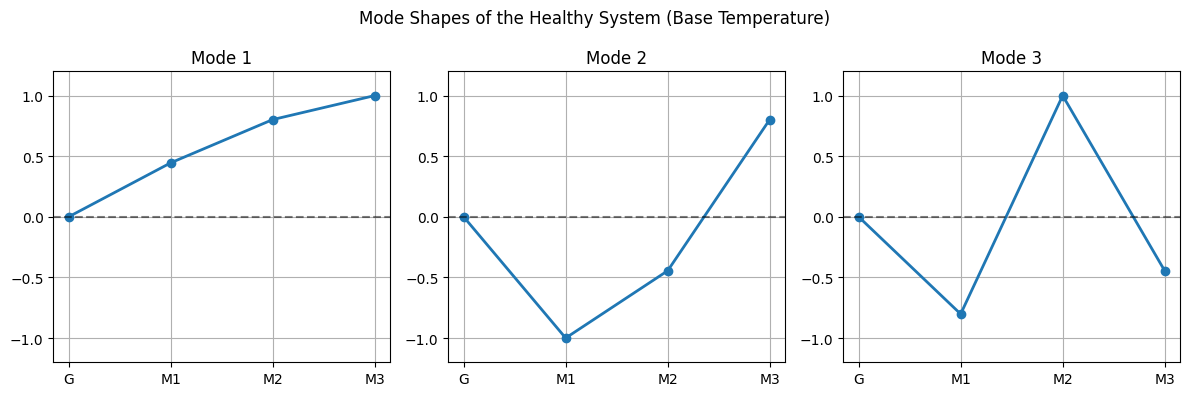

In [31]:
def plot_mode_shapes(K, M):
    evals, evecs = eigh(K, M)
    
    plt.figure(figsize=(12, 4))
    positions = [0, 1, 2, 3] # Ground, m1, m2, m3
    
    for i in range(3):
        mode_shape = np.r_[0, evecs[:, i]] # Add ground (0 displacement)
        # Normalize max displacement to 1 for visualization
        mode_shape = mode_shape / np.max(np.abs(mode_shape))
        
        plt.subplot(1, 3, i+1)
        plt.plot(positions, mode_shape, 'o-', lw=2)
        plt.axhline(0, color='k', linestyle='--', alpha=0.5)
        plt.title(f'Mode {i+1}')
        plt.xticks(positions, ['G', 'M1', 'M2', 'M3'])
        plt.ylim(-1.2, 1.2)
        plt.grid(True)
        
    plt.suptitle('Mode Shapes of the Healthy System (Base Temperature)')
    plt.tight_layout()
    plt.show()

# Plot mode shapes for base stiffness
K_base = get_stiffness_matrix(k0, k0, k0)
plot_mode_shapes(K_base, M)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set seed for reproducibility
np.random.seed(42)

# System Parameters
m = 1.0  # Mass (kg)
k0 = 1000.0  # Base Stiffness (N/m)

# Mass Matrix (Lumped mass)
M = np.diag([m, m, m])

def get_stiffness_matrix(k1, k2, k3):
    """
    Constructs the stiffness matrix for a 3DOF chain system.
    Ground - k1 - m1 - k2 - m2 - k3 - m3
    """
    K = np.array([
        [k1 + k2, -k2, 0],
        [-k2, k2 + k3, -k3],
        [0, -k3, k3]
    ])
    return K

def solve_eigenfrequencies(K, M):
    """
    Solves the generalized eigenvalue problem K * phi = w^2 * M * phi
    Returns natural frequencies in Hz.
    """
    evals, evecs = eigh(K, M)
    frequencies = np.sqrt(evals) / (2 * np.pi)
    return frequencies

print("System functions defined.")

System functions defined.


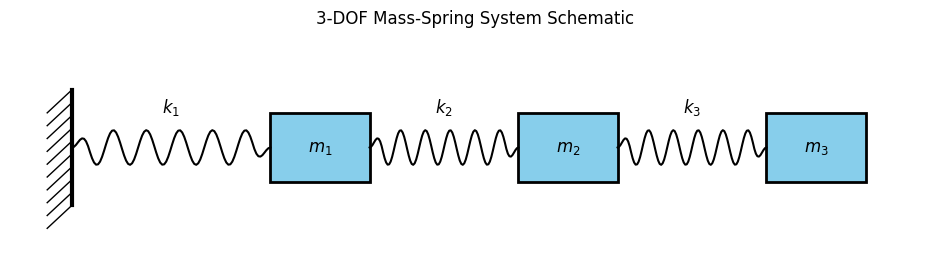

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh
from scipy import signal
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Set seed for reproducibility
np.random.seed(42)

# System Parameters
m = 1.0  # Mass (kg)
k0 = 1000.0  # Base Stiffness (N/m)

# Mass Matrix (Lumped mass)
M = np.diag([m, m, m])

def get_stiffness_matrix(k1, k2, k3):
    """
    Constructs the stiffness matrix for a 3DOF chain system.
    Ground - k1 - m1 - k2 - m2 - k3 - m3
    """
    K = np.array([
        [k1 + k2, -k2, 0],
        [-k2, k2 + k3, -k3],
        [0, -k3, k3]
    ])
    return K

def get_damping_matrix(M, K, alpha=0.01, beta=0.001):
    """
    Rayleigh Damping: C = alpha*M + beta*K
    """
    return alpha * M + beta * K

def solve_eigenfrequencies(K, M):
    """
    Solves the generalized eigenvalue problem K * phi = w^2 * M * phi
    Returns natural frequencies in Hz.
    """
    evals, evecs = eigh(K, M)
    frequencies = np.sqrt(evals) / (2 * np.pi)
    return frequencies

print("System functions defined (Mass, Stiffness, Damping).")

## 2. Simulating System Response (PSD)

In a real-world scenario, we don't measure stiffness matrices directly. We measure acceleration response to ambient excitation (like wind or traffic), which can be modeled as **White Noise**.

We will:
1. Apply White Noise force to the system.
2. Simulate the time-domain response.
3. Compute the **Power Spectral Density (PSD)** to identify the resonance frequencies.

## 2. Simulating Environmental Effect (Temperature)

We assume that temperature affects the stiffness of the material (Young's modulus decreases as temperature increases).
We will simulate a range of temperatures and calculate the natural frequencies for the "Healthy" system under these varying conditions.

Model: $k(T) = k_0 \times (1 - \alpha \times T)$

In [25]:
# Simulation Parameters
n_samples = 100
temperatures = np.linspace(-10, 40, n_samples) # Temperature range from -10 to 40 degrees
alpha = 0.01 # Stiffness reduction coefficient per degree

# Store frequencies
healthy_freqs = []

for T in temperatures:
    # Stiffness decreases with temperature
    current_k = k0 * (1 - alpha * T)
    
    # All springs affected equally by global temperature
    K = get_stiffness_matrix(current_k, current_k, current_k)
    
    freqs = solve_eigenfrequencies(K, M)
    healthy_freqs.append(freqs)

healthy_freqs = np.array(healthy_freqs)

# Add some measurement noise
noise_level = 0.05 # Hz
healthy_freqs_noisy = healthy_freqs + np.random.normal(0, noise_level, healthy_freqs.shape)

print(f"Simulated {n_samples} healthy samples under varying temperature.")

Simulated 100 healthy samples under varying temperature.


## 3. Visualizing the Effect of Temperature

Let's plot the resonance frequencies against temperature. We expect a downward trend.

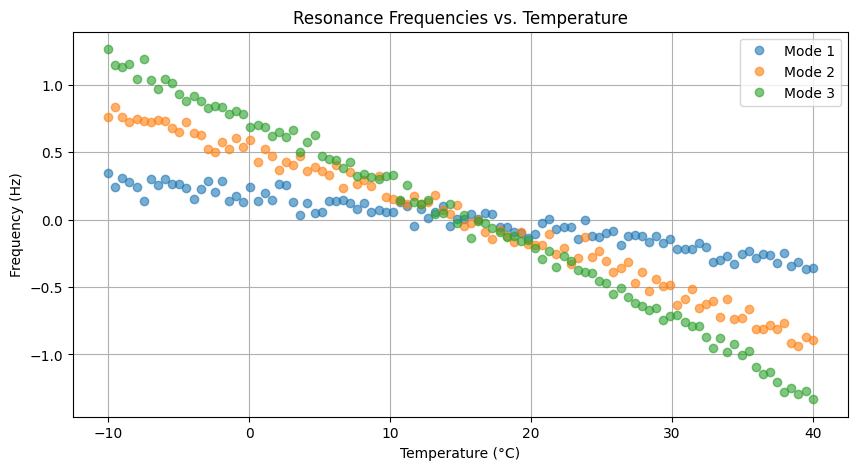

In [26]:
plt.figure(figsize=(10, 5))
for i in range(3):
    plt.plot(temperatures, healthy_freqs_noisy[:, i]-np.mean(healthy_freqs_noisy[:, i]), 'o', label=f'Mode {i+1}', alpha=0.6)

plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency (Hz)')
plt.title('Resonance Frequencies vs. Temperature')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

p = ax.scatter(healthy_freqs_noisy[:, 0], healthy_freqs_noisy[:, 1], healthy_freqs_noisy[:, 2], c=temperatures, cmap='viridis', s=50)
ax.set_xlabel('Freq Mode 1 (Hz)')
ax.set_ylabel('Freq Mode 2 (Hz)')
ax.set_zlabel('Freq Mode 3 (Hz)')
ax.set_title('3D Trajectory of Frequencies with Temperature')
fig.colorbar(p, label='Temperature (°C)')
plt.show()

## 4. Correlation between Frequencies

Since temperature is a global latent variable affecting all modes, the frequencies are highly correlated. Let's plot Frequency 1 vs Frequency 2.

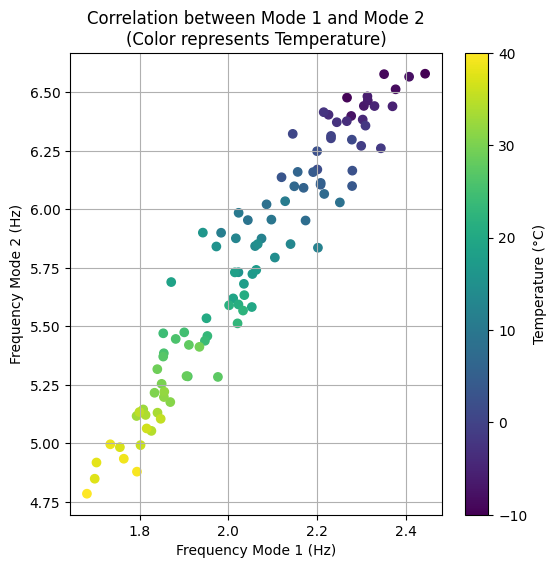

In [20]:
plt.figure(figsize=(6, 6))
plt.scatter(healthy_freqs_noisy[:, 0], healthy_freqs_noisy[:, 1], c=temperatures, cmap='viridis')
plt.xlabel('Frequency Mode 1 (Hz)')
plt.ylabel('Frequency Mode 2 (Hz)')
plt.title('Correlation between Mode 1 and Mode 2\n(Color represents Temperature)')
plt.colorbar(label='Temperature (°C)')
plt.grid(True)
plt.show()

In [ ]:
plt.figure(figsize=(6, 5))
corr_matrix = np.corrcoef(healthy_freqs_noisy.T)
plt.imshow(corr_matrix, cmap='coolwarm', vmin=-1, vmax=1)
plt.colorbar(label='Correlation Coefficient')
plt.xticks([0, 1, 2], ['Mode 1', 'Mode 2', 'Mode 3'])
plt.yticks([0, 1, 2], ['Mode 1', 'Mode 2', 'Mode 3'])

# Add text annotations
for i in range(3):
    for j in range(3):
        plt.text(j, i, f"{corr_matrix[i, j]:.2f}", ha='center', va='center', color='black', fontweight='bold')

plt.title('Correlation Matrix of Frequencies')
plt.show()

## 5. PCA for Environmental Compensation

We use Principal Component Analysis (PCA) to learn the subspace of variations caused by temperature.
- **PC1** should capture the temperature effect (maximum variance).
- **Residuals** (or higher PCs) should contain noise.

If damage occurs, it will likely change the physics in a way that doesn't align perfectly with the temperature effect, or it will push the data outside the normal operating range.

Explained variance ratio: [0.9808934  0.01713128 0.00197532]


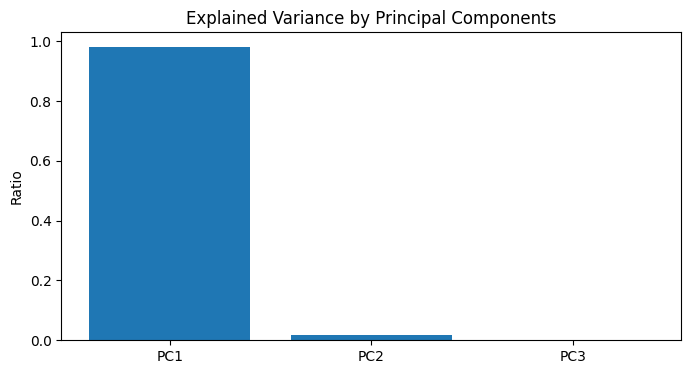

In [21]:
# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(healthy_freqs_noisy)

# Apply PCA
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X_train)

print("Explained variance ratio:", pca.explained_variance_ratio_)

plt.figure(figsize=(8, 4))
plt.bar(['PC1', 'PC2', 'PC3'], pca.explained_variance_ratio_)
plt.title('Explained Variance by Principal Components')
plt.ylabel('Ratio')
plt.show()

## 6. Simulating Damage

Now we simulate a **Damage** scenario.
Damage is modeled as a local stiffness reduction in **Spring 1 ($k_1$) only**.
This is different from temperature which affects $k_1, k_2, k_3$ globally.

We will simulate damage at a specific temperature (e.g., 20°C).

In [27]:
# Damage Simulation
T_damage = 20.0 # Temperature during damage measurement
k_temp = k0 * (1 - alpha * T_damage) # Baseline stiffness at this temp

# Damage: 10% reduction in k1
damage_factor = 0.5 
k1_damaged = k_temp * damage_factor
k2_undamaged = k_temp
k3_undamaged = k_temp

K_damaged = get_stiffness_matrix(k1_damaged, k2_undamaged, k3_undamaged)
freqs_damaged = solve_eigenfrequencies(K_damaged, M)

# Add noise
freqs_damaged_noisy = freqs_damaged + np.random.normal(0, noise_level, freqs_damaged.shape)

# Reshape for PCA (1 sample, 3 features)
freqs_damaged_noisy = freqs_damaged_noisy.reshape(1, -1)

print("Damaged frequencies calculated.")
print("Healthy (approx at 20C):", healthy_freqs[np.abs(temperatures - 20).argmin()])
print("Damaged:", freqs_damaged)

Damaged frequencies calculated.
Healthy (approx at 20C): [2.00592022 5.62046355 8.12180514]
Damaged: [1.60243581 5.07811116 7.92679328]


## 6.1 Visualizing Damage in Frequency Domain

Before applying PCA, let's look at the raw First Natural Frequency ($f_1$) vs Temperature.
We want to see if the damage (stiffness reduction) is distinguishable from the temperature effect just by looking at this plot.

In [ ]:
plt.figure(figsize=(10, 6))

# Plot Healthy Data (Mode 1)
plt.plot(temperatures, healthy_freqs_noisy[:, 0], 'o', label='Healthy (varying Temp)', color='blue', alpha=0.6)

# Plot Damaged Data (Mode 1)
plt.plot(T_damage, freqs_damaged_noisy[0, 0], 'X', label='Damaged', color='red', markersize=15)

plt.xlabel('Temperature (°C)')
plt.ylabel('Frequency Mode 1 (Hz)')
plt.title('Effect of Damage on First Natural Frequency')
plt.legend()
plt.grid(True)
plt.show()

## 7. Damage Detection using PCA

We project the damaged data onto the PCA space defined by the healthy data.

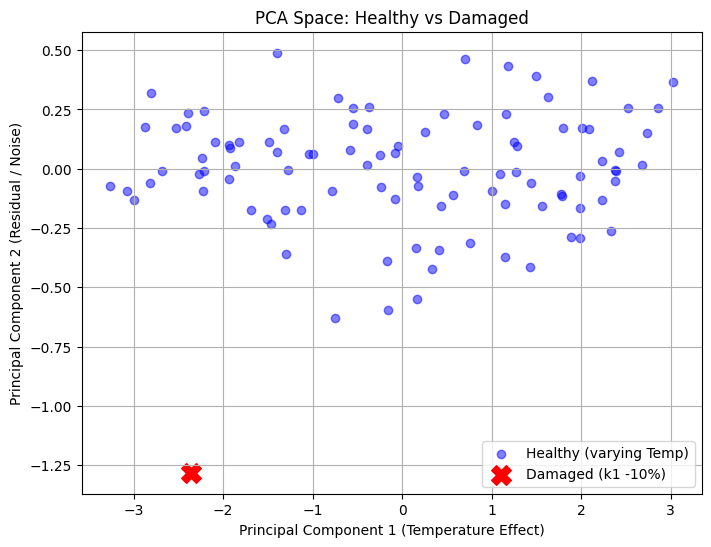

In [29]:
# Transform damaged data using the SAME scaler and PCA
X_damage_std = scaler.transform(freqs_damaged_noisy)
X_damage_pca = pca.transform(X_damage_std)

# Plotting PC1 vs PC2
plt.figure(figsize=(8, 6))

# Plot Healthy Data
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='blue', label='Healthy (varying Temp)', alpha=0.5)

# Plot Damaged Data
plt.scatter(X_damage_pca[:, 0], X_damage_pca[:, 1], c='red', s=200, marker='X', label='Damaged (k1 -10%)')

plt.xlabel('Principal Component 1 (Temperature Effect)')
plt.ylabel('Principal Component 2 (Residual / Noise)')
plt.title('PCA Space: Healthy vs Damaged')
plt.legend()
plt.grid(True)
plt.show()

### Interpretation
- The **Blue points** form a line (manifold) representing the system state under varying temperature.
- The **Red X** represents the damaged state.
- If the Red X falls significantly away from the Blue cluster (especially in the PC2 direction, which represents deviations from the global trend), it indicates an anomaly (Damage).

## 8. Verification: Removing the Temperature Effect

We claimed that PCA can remove the environmental effect without measuring it.
Since **PC1** captures the maximum variance (which we suspect is temperature-driven), **PC2 and PC3** represent the data with the main trend removed.

Let's verify this by plotting **PC1** and **PC2** against the actual Temperature (which we know for the simulation, even though the model didn't use it).

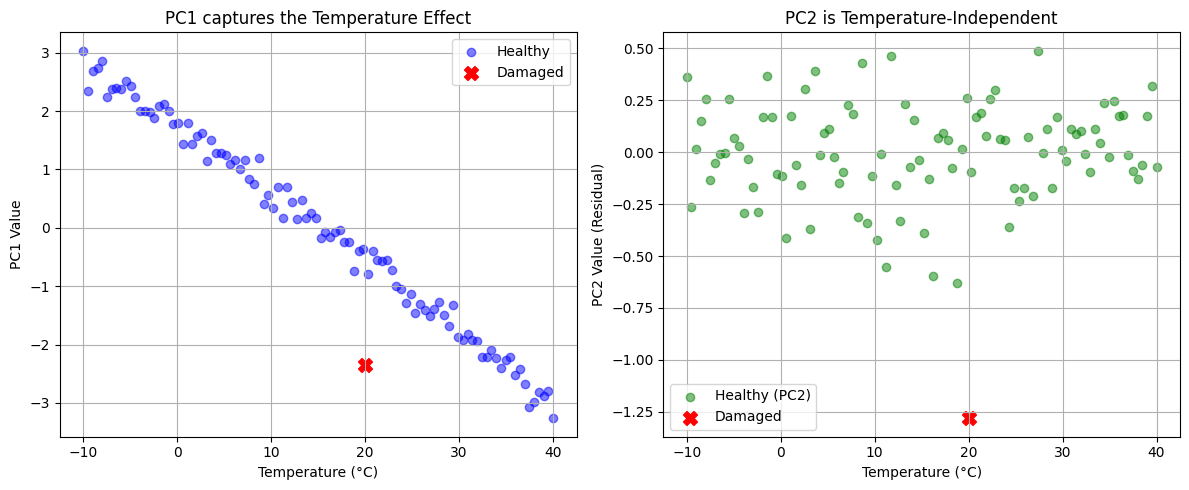

In [30]:
plt.figure(figsize=(12, 5))

# Subplot 1: PC1 vs Temperature
plt.subplot(1, 2, 1)
plt.scatter(temperatures, X_pca[:, 0], c='blue', alpha=0.5, label='Healthy')
plt.scatter([T_damage], [X_damage_pca[0, 0]], c='red', marker='X', s=100, label='Damaged')
plt.xlabel('Temperature (°C)')
plt.ylabel('PC1 Value')
plt.title('PC1 captures the Temperature Effect')
plt.legend()
plt.grid(True)

# Subplot 2: PC2 vs Temperature
plt.subplot(1, 2, 2)
plt.scatter(temperatures, X_pca[:, 1], c='green', alpha=0.5, label='Healthy (PC2)')
plt.scatter([T_damage], [X_damage_pca[0, 1]], c='red', marker='X', s=100, label='Damaged')
plt.xlabel('Temperature (°C)')
plt.ylabel('PC2 Value (Residual)')
plt.title('PC2 is Temperature-Independent')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

### Conclusion
- **Left Plot**: PC1 has a near-perfect linear relationship with temperature. The model "discovered" temperature as the main driver of change without being given temperature data.
- **Right Plot**: PC2 is flat (around zero) across the entire temperature range. The temperature effect has been **removed** in this dimension.
- The **Damaged point** (Red X) clearly stands out in the PC2 plot, whereas in the raw frequency plots (or PC1), it might be masked by the temperature variations.

In [ ]:
# Calculate Mahalanobis Distance in the Residual Subspace (PC2, PC3)
# We use the healthy data to define the "normal" distribution of residuals

# Extract PC2 and PC3 for healthy data (ignoring PC1 which is temperature)
residuals_healthy = X_pca[:, 1:] # Columns 1 and 2 (PC2, PC3)
mean_res = np.mean(residuals_healthy, axis=0)
cov_res = np.cov(residuals_healthy.T)
inv_cov_res = np.linalg.inv(cov_res)

def calculate_mahalanobis(data_pca):
    # data_pca shape (n_samples, n_components)
    residuals = data_pca[:, 1:]
    diff = residuals - mean_res
    # MD = sqrt(diff * inv_cov * diff.T)
    # We use diag to get the diagonal elements of the result matrix (distance for each sample)
    md = np.sqrt(np.diag(diff @ inv_cov_res @ diff.T))
    return md

md_healthy = calculate_mahalanobis(X_pca)
md_damaged = calculate_mahalanobis(X_damage_pca)

# Threshold (e.g., 99% confidence interval of healthy data)
threshold = np.percentile(md_healthy, 99)

plt.figure(figsize=(10, 5))
plt.plot(md_healthy, 'o', label='Healthy Samples')
plt.plot([len(md_healthy)], md_damaged, 'X', color='red', markersize=15, label='Damaged Sample')
plt.axhline(threshold, color='r', linestyle='--', label='99% Threshold')
plt.xlabel('Sample Index')
plt.ylabel('Damage Index (Mahalanobis Dist. on Residuals)')
plt.title('Automated Damage Detection: Damage Index')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def simulate_and_plot_psd(k_vals, label="Healthy"):
    # 1. Define System Matrices
    K = get_stiffness_matrix(*k_vals)
    C = get_damping_matrix(M, K)
    
    # 2. State Space Representation for scipy.signal.lsim
    # State vector z = [x1, x2, x3, v1, v2, v3]
    # M*acc + C*vel + K*pos = F
    # acc = M_inv * (F - C*vel - K*pos)
    
    M_inv = np.linalg.inv(M)
    A_bottom = np.hstack([-M_inv @ K, -M_inv @ C])
    A_top = np.hstack([np.zeros((3,3)), np.eye(3)])
    A = np.vstack([A_top, A_bottom])
    
    # Input: Force on all masses (3 inputs)
    # B matrix: 
    B_top = np.zeros((3, 3))
    B_bottom = M_inv
    B = np.vstack([B_top, B_bottom])
    
    # Output: Acceleration at Mass 3 (or all)
    # y = C_out * z + D_out * u
    # acc = M_inv * (F - C*vel - K*pos)
    # Let's just output Displacement for simplicity of viewing, or Acceleration.
    # Let's output Acceleration of Mass 3.
    # Acc3 is the last row of the equation of motion.
    # C_out row for Acc3: [-M_inv[2,:]@K, -M_inv[2,:]@C]
    C_out = np.hstack([-M_inv @ K, -M_inv @ C]) # Returns acc for all 3 masses
    D_out = M_inv # Direct feedthrough of force
    
    # 3. Generate White Noise Excitation
    fs = 100.0 # Sampling frequency (Hz)
    T = 60.0   # Duration (s)
    t = np.arange(0, T, 1/fs)
    n_points = len(t)
    force = np.random.normal(0, 1, (n_points, 3)) # Random force on all masses
    
    # 4. Simulate
    sys = signal.StateSpace(A, B, C_out, D_out)
    _, y, _ = signal.lsim(sys, force, t)
    acc_m3 = y[:, 2] # Acceleration of Mass 3
    
    # 5. Compute PSD (Welch's Method)
    f, Pxx = signal.welch(acc_m3, fs, nperseg=1024)
    
    # 6. Plot
    plt.figure(figsize=(12, 4))
    
    # Time History
    plt.subplot(1, 2, 1)
    plt.plot(t[:500], acc_m3[:500], lw=0.5) # Show first 5 seconds
    plt.title(f'Time History (Acceleration M3) - {label}')
    plt.xlabel('Time (s)')
    plt.ylabel('Acc ($m/s^2$)')
    plt.grid(True)
    
    # PSD
    plt.subplot(1, 2, 2)
    plt.semilogy(f, Pxx)
    plt.title(f'PSD (Power Spectral Density) - {label}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('PSD')
    plt.xlim(0, 15)
    plt.grid(True)
    
    # Mark theoretical frequencies
    freqs_theoretical = solve_eigenfrequencies(K, M)
    for fr in freqs_theoretical:
        plt.axvline(fr, color='r', linestyle='--', alpha=0.5)
        plt.text(fr, np.max(Pxx), f'{fr:.2f}Hz', rotation=90, verticalalignment='top')
        
    plt.tight_layout()
    plt.show()
    
    return freqs_theoretical

# Run simulation for base parameters
print("Simulating response to white noise...")
base_freqs = simulate_and_plot_psd([k0, k0, k0], "Healthy (20°C)")